In [1]:
from junifer.storage import HDF5FeatureStorage
from julearn.api import run_cross_validation
from julearn.pipeline import PipelineCreator
import pandas as pd
import seaborn as sns
from sklearn.svm import LinearSVC

It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
/home/hsreekri/Hsreekri/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



In [23]:
storage = HDF5FeatureStorage(uri='data/AOMICID1000_vbm_parcellations_sch100.hdf5')


In [24]:
df = storage.read_df('VBM_GM_Schaefer100x17_counts_aggregation')

In [25]:
df

,LH_VisCent_ExStr_1,LH_VisCent_ExStr_2,LH_VisCent_Striate_1,LH_VisCent_ExStr_3,LH_VisPeri_ExStrInf_1,LH_VisPeri_StriCal_1,LH_VisPeri_ExStrSup_1,LH_SomMotA_1,LH_SomMotA_2,LH_SomMotB_Aud_1,...,RH_DefaultA_pCunPCC_1,RH_DefaultA_PFCm_1,RH_DefaultB_PFCd_1,RH_DefaultB_PFCv_1,RH_DefaultB_PFCv_2,RH_DefaultC_Rsp_1,RH_DefaultC_PHC_1,RH_TempPar_1,RH_TempPar_2,RH_TempPar_3
subject,,,,,,,,,,,,,,,,,,,,,
sub-0600,7970.0,10533.0,7358.0,11134.0,6808.0,7166.0,7550.0,9940.0,13890.0,9696.0,...,6208.0,12081.0,14883.0,5358.0,7056.0,3662.0,8389.0,7384.0,8498.0,5477.0
sub-0618,7970.0,10533.0,7358.0,11134.0,6808.0,7166.0,7550.0,9940.0,13890.0,9696.0,...,6208.0,12081.0,14883.0,5358.0,7056.0,3662.0,8389.0,7384.0,8498.0,5477.0
sub-0832,7970.0,10533.0,7358.0,11134.0,6808.0,7166.0,7550.0,9940.0,13890.0,9696.0,...,6208.0,12081.0,14883.0,5358.0,7056.0,3662.0,8389.0,7384.0,8498.0,5477.0
sub-0740,7970.0,10533.0,7358.0,11134.0,6808.0,7166.0,7550.0,9940.0,13890.0,9696.0,...,6208.0,12081.0,14883.0,5358.0,7056.0,3662.0,8389.0,7384.0,8498.0,5477.0
sub-0758,7970.0,10533.0,7358.0,11134.0,6808.0,7166.0,7550.0,9940.0,13890.0,9696.0,...,6208.0,12081.0,14883.0,5358.0,7056.0,3662.0,8389.0,7384.0,8498.0,5477.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub-0893,7970.0,10533.0,7358.0,11134.0,6808.0,7166.0,7550.0,9940.0,13890.0,9696.0,...,6208.0,12081.0,14883.0,5358.0,7056.0,3662.0,8389.0,7384.0,8498.0,5477.0
sub-0561,7970.0,10533.0,7358.0,11134.0,6808.0,7166.0,7550.0,9940.0,13890.0,9696.0,...,6208.0,12081.0,14883.0,5358.0,7056.0,3662.0,8389.0,7384.0,8498.0,5477.0
sub-0579,7970.0,10533.0,7358.0,11134.0,6808.0,7166.0,7550.0,9940.0,13890.0,9696.0,...,6208.0,12081.0,14883.0,5358.0,7056.0,3662.0,8389.0,7384.0,8498.0,5477.0


In [26]:
df_demographics = pd.read_csv('data/participants.tsv',sep='\t')

In [27]:
df_demographics.rename(columns={"participant_id": "subject"}, inplace=True)

In [28]:
df_demographics

,subject,age,sex,BMI,handedness,education_category,raven_score,NEO_N,NEO_E,NEO_O,NEO_A,NEO_C
0,sub-0001,25.50,M,21.0,right,academic,33.0,23,40,52,47,32
1,sub-0002,23.25,F,22.0,right,academic,19.0,22,47,34,53,46
2,sub-0003,25.00,F,23.0,right,applied,29.0,26,42,37,48,48
3,sub-0004,20.00,F,18.0,right,academic,24.0,32,42,36,48,52
4,sub-0005,24.75,M,27.0,right,academic,24.0,32,51,41,51,53
...,...,...,...,...,...,...,...,...,...,...,...,...
221,sub-0222,22.00,F,20.0,right,academic,30.0,41,35,51,48,42
222,sub-0223,20.75,F,23.0,left,applied,26.0,33,41,54,36,41
223,sub-0224,21.75,M,20.0,right,academic,34.0,22,45,47,46,46
224,sub-0225,20.25,F,28.0,right,academic,27.0,48,32,43,42,37


In [36]:
df.columns = df.columns.astype(str)
X = list(df.columns)
df_full = df.merge(df_demographics, on="subject")

In [37]:
df_full['sex'] = df_full['sex'].map({'F': 1, 'M': 0})
df_full['sex']

df_full = df_full.dropna()

In [38]:
creator = PipelineCreator(problem_type="classification")
creator.add("zscore")
creator.add(
    "svm",
    C=(0.001, 100, "log-uniform"),
)

In [39]:
search_params = {
    "kind": "optuna",
    "cv": 5,
}
scores, model, inspector = run_cross_validation(
    X=X,
    y='sex',
    data=df_full,
    search_params=search_params,
    model=creator,
    return_train_score=True,
    return_inspector=True,
    cv=5,
)

/home/hsreekri/Hsreekri/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['LH_VisCent_ExStr_1', 'LH_VisCent_ExStr_2', 'LH_VisCent_Striate_1', 'LH_VisCent_ExStr_3', 'LH_VisPeri_ExStrInf_1', 'LH_VisPeri_StriCal_1', 'LH_VisPeri_ExStrSup_1', 'LH_SomMotA_1', 'LH_SomMotA_2', 'LH_SomMotB_Aud_1', 'LH_SomMotB_S2_1', 'LH_SomMotB_S2_2', 'LH_SomMotB_Cent_1', 'LH_DorsAttnA_TempOcc_1', 'LH_DorsAttnA_ParOcc_1', 'LH_DorsAttnA_SPL_1', 'LH_DorsAttnB_PostC_1', 'LH_DorsAttnB_PostC_2', 'LH_DorsAttnB_PostC_3', 'LH_DorsAttnB_FEF_1', 'LH_SalVentAttnA_ParOper_1', 'LH_SalVentAttnA_Ins_1', 'LH_SalVentAttnA_Ins_2', 'LH_SalVentAttnA_ParMed_1', 'LH_SalVentAttnA_FrMed_1', 'LH_SalVentAttnB_PFCl_1', 'LH_SalVentAttnB_PFCmp_1', 'LH_LimbicB_OFC_1', 'LH_LimbicA_TempPole_1', 'LH_LimbicA_TempPole_2', 'LH_ContA_IPS_1', 'LH_ContA_PFCl_1', 'LH_ContA_PFCl_2', 'LH_ContB_PFClv_1', 'LH_ContC_pCun_1', 'LH_ContC_pCun_2', 'LH_ContC_Cingp_1', 'LH_DefaultA_PFCd_1', '

In [40]:
scores

,fit_time,score_time,estimator,test_score,train_score,n_train,n_test,repeat,fold,cv_mdsum
0,0.381494,0.002571,"OptunaSearchCV(cv=KFold(n_splits=5, random_sta...",0.555556,0.575419,179,45,0,0,b10eef89b4192178d482d7a1587a248a
1,0.388104,0.002573,"OptunaSearchCV(cv=KFold(n_splits=5, random_sta...",0.666667,0.547486,179,45,0,1,b10eef89b4192178d482d7a1587a248a
2,0.381822,0.002522,"OptunaSearchCV(cv=KFold(n_splits=5, random_sta...",0.511111,0.586592,179,45,0,2,b10eef89b4192178d482d7a1587a248a
3,0.374846,0.002461,"OptunaSearchCV(cv=KFold(n_splits=5, random_sta...",0.555556,0.575419,179,45,0,3,b10eef89b4192178d482d7a1587a248a
4,0.373050,0.002501,"OptunaSearchCV(cv=KFold(n_splits=5, random_sta...",0.568182,0.572222,180,44,0,4,b10eef89b4192178d482d7a1587a248a


<Axes: >

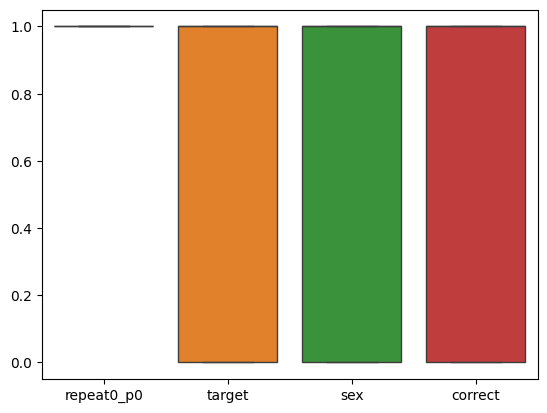

In [43]:
# %%
predictions = inspector.folds.predict()
to_merge = df_full[["sex"]].iloc[predictions.index]
to_plot = pd.concat([predictions, to_merge], axis=1)


# %%
to_plot["correct"] = to_plot["repeat0_p0"] == to_plot["target"]
# %%
sns.boxplot(data=to_plot)


In [44]:
scores = run_cross_validation(
    X=X,
    y='sex',
    data=df_full,
    model="svm",
    problem_type="classification",
    preprocess="zscore",
)

print(scores["test_score"])

/home/hsreekri/Hsreekri/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['LH_VisCent_ExStr_1', 'LH_VisCent_ExStr_2', 'LH_VisCent_Striate_1', 'LH_VisCent_ExStr_3', 'LH_VisPeri_ExStrInf_1', 'LH_VisPeri_StriCal_1', 'LH_VisPeri_ExStrSup_1', 'LH_SomMotA_1', 'LH_SomMotA_2', 'LH_SomMotB_Aud_1', 'LH_SomMotB_S2_1', 'LH_SomMotB_S2_2', 'LH_SomMotB_Cent_1', 'LH_DorsAttnA_TempOcc_1', 'LH_DorsAttnA_ParOcc_1', 'LH_DorsAttnA_SPL_1', 'LH_DorsAttnB_PostC_1', 'LH_DorsAttnB_PostC_2', 'LH_DorsAttnB_PostC_3', 'LH_DorsAttnB_FEF_1', 'LH_SalVentAttnA_ParOper_1', 'LH_SalVentAttnA_Ins_1', 'LH_SalVentAttnA_Ins_2', 'LH_SalVentAttnA_ParMed_1', 'LH_SalVentAttnA_FrMed_1', 'LH_SalVentAttnB_PFCl_1', 'LH_SalVentAttnB_PFCmp_1', 'LH_LimbicB_OFC_1', 'LH_LimbicA_TempPole_1', 'LH_LimbicA_TempPole_2', 'LH_ContA_IPS_1', 'LH_ContA_PFCl_1', 'LH_ContA_PFCl_2', 'LH_ContB_PFClv_1', 'LH_ContC_pCun_1', 'LH_ContC_pCun_2', 'LH_ContC_Cingp_1', 'LH_DefaultA_PFCd_1', '

0    0.555556
1    0.666667
2    0.511111
3    0.555556
4    0.568182
Name: test_score, dtype: float64
